### 1. Общее описание проекта.

#### 1.1. Введение.

<div align='justify' style="text-indent:2em"> Целью настоящего проекта является создание наилучшей прогнозной модели покупательской активности клиентов интернет-магазина (далее - Заказчика проекта). С этой целью Заказчик распределяет своих клиентов на два класса: класс 0 составляют те клиенты, которые по оценке Заказчика не готовы совершить покупку у него в течение 90 дней со дня проведения этой оценки, класс 1 составляют те клиенты Заказчика, которые, напротив, готовы совершить у него покупку в течение 90 дней. Для цели прогнозного моделирования Заказчик предоставляет доступ к файлу, в котором клиенты распределены по классам 0 и 1. Также Заказчик предоставляет проектанту доступ к файлам своих рекламных кампаний и покупок клиентов. Особенностью проекта является отсутствие у Заказчика структурированных данных по факторам, влияющим на классификацию клиентов, а также перечня самих таких факторов. Проектант должен самостоятельно, опираясь на здравый смысл и общую информацию о розничном маркетинге, определить факторы, которые влияют на покупательскую активность клиента и его классификацию. Далее в проекте эти факторы будут именоваться входными признаками, а значения классов (0 и 1) - целевым признаком. Задача моделирования будет сведена к задаче вычисления вероятности отнесения клиентов к одному из двух классов (задача бинарной классификации) на основании статистических корреляций между значением целевого признака и значениями входных признаков. Таким образом, структура проекта будет включать в себя пять частей (разделов): первая - общее описание проекта, вторая - гипотетическое (экспертное) формирование перечня входных признаков и соответствующее этому перечню структурирование предоставленных Заказчиком данных, третья - проведение собственно моделирования (создание прогнозных моделей) и оценки качества моделей (тестирование), четвёртая - анализ результатов моделирования и выработка рекомендаций Заказчику и пятая - подведение итогов проекта. В каждом разделе проекта (кроме пятого) будут подведены итоги выполнения задач раздела. Заказчик установил ограничение для принятия проекта как успешно выполненного: метрика прогнозной модели ROC-AUC на тестовых данных Заказчика должна быть более 0,7. </div>

#### 1.2. Описание гипотез.

<div align='justify' style="text-indent:2em"> 
    Гипотезами о том, какие признаки могут быть входными, то есть влиять на целевой признак (класс клиента) в этом проекте являются следующие. 
<br> 1. &nbsp; Количества рекламных событий у клиента (раздельно по каналам рекламы) и событий покупки клиентом товаров (каждый вид пары: события и канала - это самостоятельный признак). Априорная логика гипотезы: чем больше рекламы, тем вероятнее клиент совершит новую покупку.
<br> 2. &nbsp; Коэффициенты конверсии в маркетинговой воронке клиента (каждый вид пары: коэффициента конверсии и рекламного канала - это самостоятельный признак). Априорная логика гипотезы: чем выше коэффициенты конверсий, тем вероятнее клиент совершит новую покупку.
<br> 3. &nbsp; Давность последих во времени рекламных событий и событий покупки товаров (индикаторы событий) и длительность позитивной реакции клиента на рекламу (время от получения рекламы товара до покупки этого товара). Априорная логика гипотезы: клиенты Заказчика, давно непокупавшие товары и/или быстро реагирующие на рекламу, более склонны к новым покупкам, чем выше давность и/или выше скорость реакции клиента на рекламу, тем вероятнее клиент совершит новую покупку.
<br> 4. &nbsp; Общая стоимость покупок клиента и средняя цена его покупок. Априорная логика гипотезы: чем выше общая стоимость покупок клиента и средняя цена его покупок, тем лояльнее клиент Заказчику, тем вероятнее клиент совершит новую покупку.
<br> 5. &nbsp; Идентификаторы товаров, купленных клиентом. Априорная логика гипотезы не ясна: возможно, если клиент ранее покупал какие-то товары (или участвовал в распродажах Заказчика), то вероятность совершения им новой покупки выше. </div>

### 2. Подготовка к моделированию.

#### 2.1. Подготовка необходимого программного обеспечения.

In [1]:
# Применим команду для создания файла с описанием зависимостей
!pip freeze > requirements.txt

In [2]:
# Инсталируем библиотеку для балансировки классов 
!pip install imbalanced-learn -q

In [3]:
# Импортируем в проект необходимые библиотеки и модули
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import shap

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier 

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import roc_auc_score, confusion_matrix

In [4]:
# Установим константу, используемую при моделировании
RANDOM_STATE = 17

In [5]:
# Создадим функцию вычисления средней метрики roc_auc переданной в функцию прогнозной модели (model) на данных 5 валидационных выборок,
# сформированных из тренировочной выборки (Х), также переданной в функцию
def calc_metric (model, X, y):
    metric_cv = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
    return metric_cv.mean()

#### 2.2. Подготовка данных для моделирования.

<div align='justify' style="text-indent:2em"> Для того, чтобы структурировать и использовать в целях этого проекта данные Заказчика, необходимо загрузить их в проект и провести их предобработку: очистить от выбросов, дубликатов, пропусков данных, если они есть, а затем трансформировать эти данные таким образом, чтобы они представляли собой значения гипотетически (экспертно) определённых входных признаков. Вслед за предобработкой данных будут проанализированы их статистические зависимости и/или распределения, а также данные будут подготовлены для моделирования. </div>

##### 2.2.1. Формирование таблиц входных признаков из файла "одежда-сообщения".

In [6]:
# Загрузим в проект данные файла 'apparel-messages.csv' в датафрейм 'df_apparel_messages'
df_apparel_messages = pd.read_csv('d:/Михаил/Training/workshop_2/data_workshop_2/apparel-messages.csv').sort_values(by='client_id')

In [7]:
# Выведем на экран общую инфориацию о созданном датафрейме 'df_apparel_messages'
df_apparel_messages.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12739798 entries, 3485204 to 12707477
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 777.6+ MB


In [8]:
# Выведем на экран первые пять строк датафрейма 'df_apparel_messages'
df_apparel_messages.head().T

,3485204,2333892,6923759,1530497,2333899
bulk_campaign_id,9148,7659,13640,6316,7659
client_id,1515915625468060902,1515915625468060902,1515915625468060902,1515915625468060902,1515915625468060902
message_id,1515915625468060902-9148-63b54b46a6cd3,1515915625468060902-7659-6368e55d61551,1515915625468060902-13640-64d5f73170e39,1515915625468060902-6316-63201ca88eb2b,1515915625468060902-7659-6368e55d61551
event,send,open,open,click,click
channel,email,email,email,email,email
date,2023-01-04,2022-11-07,2023-08-11,2022-09-14,2022-11-07
created_at,2023-01-04 10:46:15,2022-11-07 15:11:58,2023-08-11 12:52:04,2022-09-14 05:29:29,2022-11-07 15:12:38


<div align='justify' style="text-indent:2em"> Дадим признаковое описание созданного датафрейма 'df_apparel_messages'. В датафрейме 12 739 798 строк и 7 столбцов со следующими данными. 
    <br>Столбец 'bulk_campaign_id' содержит идентификаторы рекламных компаний Заказчика.
    <br>Столбец 'client_id' содержит идентификаторы клиентов Заказчика.
    <br>Столбец 'message_id' содержит идентификаторы рекламных сообщений Заказчика клиенту.
    <br>Столбец 'event' содержит наименования видов рекламных событий и события покупки клиентом товара у Заказчика.
    <br>Столбец 'channel' содержит наименования видов рекламных каналов клиентов Заказчика.
    <br>Столбец 'date' содержит даты рекламных событий и события покупки клиентом товара у Заказчика.
    <br>Столбец 'created_at' содержит даты и время создания записей.
    <br>&emsp;&emsp;Три столбца идентификаторов содержат данные категориального (порядкового) типа, два столбца наименований содержат данные категориального (номинального) типа, два столбца содержат данные дат и времени. </div>

In [9]:
# Выведем на экран все уникальные значения столбца 'df_apparel_messages['event']'
df_apparel_messages['event'].unique()

array(['send', 'open', 'click', 'purchase', 'unsubscribe', 'hard_bounce',
       'soft_bounce', 'hbq_spam', 'complain', 'subscribe', 'close'],
      dtype=object)

In [10]:
# Выведем на экран все уникальные значения столбца 'df_apparel_messages['channel']'
df_apparel_messages['channel'].unique()

array(['email', 'mobile_push'], dtype=object)

In [11]:
# Удалим из датафрейма  'apparel_messages' дубликаты, если они есть
df_apparel_messages = df_apparel_messages.drop_duplicates()
print(f'Размеры датафрейма "df_apparel_messages" после удаления дубликатов: {df_apparel_messages.shape}.')

Размеры датафрейма "df_apparel_messages" после удаления дубликатов: (12691188, 7).


<div align='justify' style="text-indent:2em"> Данные созданного датафрейма 'apparel_messages' позволяют создать входные признаки, описанные ранее сформулированными гипотезами 1, 2 и 3. Для этого нужно преобразовать тип данных с датами, чтобы проводить математические операции с ними, и агрегировать (группировать) данные датафрейма по уникальным идентификаторам клиентов (по клиентам). </div>

In [12]:
# Создадим столбцец 'df_apparel_messages['form_date']' с нужным форматом данных о датах событий, сохраним самую раннюю дату и выведем ее на экран
df_apparel_messages['form_date'] = pd.to_datetime(df_apparel_messages['date'])
earliest_date = df_apparel_messages['form_date'].min()
print(f'Дата самого раннего события в датафрейме "df_apparel_messages": {earliest_date}.')

Дата самого раннего события в датафрейме "df_apparel_messages": 2022-05-19 00:00:00.


In [13]:
# Создадим датафрейм с идентификаторами клиентов и рекламных сообщений и датами отправки этих сообщений клиентам
df_apparel_send = df_apparel_messages.query('event == "send"')[['message_id', 'client_id', 'date']]

# Выведем на экран размеры датафрейма 'df_apparel_send' 
print(f'Размеры датафрейма "df_apparel_send": {df_apparel_send.shape}.')

Размеры датафрейма "df_apparel_send": (9058174, 3).


In [14]:
# Создадим датафрейм с идентификаторами клиентов и рекламных сообщений и датами покупки клиентами товаров
df_apparel_purch = df_apparel_messages.query('event == "purchase"')[['message_id', 'client_id', 'date']]

# Выведем на экран размеры датафрейма 'df_apparel_purch' 
print(f'Размеры датафрейма "df_apparel_purch": {df_apparel_purch.shape}.')

Размеры датафрейма "df_apparel_purch": (62593, 3).


In [15]:
# Объединим созданные датафреймы с датами и добавим столбцы с длительностью от самой ранней даты до события (индикатор события) 
df_send_purch = pd.merge(df_apparel_purch, df_apparel_send, on=['client_id', 'message_id'], suffixes=('_purchase', '_sending'))
df_send_purch['date_purchase'] = pd.to_datetime(df_send_purch['date_purchase'])
df_send_purch['date_sending'] = pd.to_datetime(df_send_purch['date_sending'])
df_send_purch['purch_after_earliest_date'] = (df_send_purch['date_purchase'] - earliest_date).dt.days
df_send_purch['send_after_earliest_date'] = (df_send_purch['date_sending'] - earliest_date).dt.days

# Выведем на экран размеры и первые пять строк датафрейма 'df_send_purch'
print(f'Размеры датафрейма "df_send_purch": {df_send_purch.shape}.')
df_send_purch.head()

Размеры датафрейма "df_send_purch": (62241, 6).


,message_id,client_id,date_purchase,date_sending,purch_after_earliest_date,send_after_earliest_date
0,1515915625468060902-4617-6290657dac196,1515915625468060902,2022-05-27,2022-05-27,8,8
1,1515915625468060902-4617-6290657dac196,1515915625468060902,2022-05-27,2022-05-27,8,8
2,1515915625468060902-4617-6290657dac196,1515915625468060902,2022-05-27,2022-05-27,8,8
3,1515915625468060902-4617-6290657dac196,1515915625468060902,2022-05-27,2022-05-27,8,8
4,1515915625468060902-4617-6290657dac196,1515915625468060902,2022-05-27,2022-05-27,8,8


In [16]:
# Добавим столбец с длительностью периода от получения рекламного сообщения до покупки клиентом рекламируемого в нём товара
df_send_purch['duration'] = (df_send_purch['date_purchase'] - df_send_purch['date_sending']).dt.days

In [17]:
# Создадим датафрейм (сводную таблицу) 'df_from_send_purch' с идентификаторами клиентов, средней для каждого клиента длительностью от получения 
# рекламного сообщения до покупки клиентом рекламируемых в нём товаров и максимальными индикаторами каждого из этих событий
df_latest_purchase = df_send_purch.pivot_table(index='client_id', values=['purch_after_earliest_date'], aggfunc='max').reset_index()
df_latest_sending = df_send_purch.pivot_table(index='client_id', values=['send_after_earliest_date'], aggfunc='max').reset_index()
df_from_send_purch = df_send_purch.pivot_table(index='client_id', values=['duration'], aggfunc='mean').reset_index()

df_from_send_purch = pd.merge(df_from_send_purch, df_latest_sending, how='left', on='client_id')
df_from_send_purch = pd.merge(df_from_send_purch, df_latest_purchase, how='left', on='client_id')
df_from_send_purch = df_from_send_purch.rename(columns={'duration': 'avg_duration'})

# Выведем на экран размеры датафрейма 'df_from_send_purch' и первые его 20 строк 
print(f'Размеры датафрейма "df_apparel_from_send_purch": {df_from_send_purch.shape}.')
df_from_send_purch.head(20)

Размеры датафрейма "df_apparel_from_send_purch": (41880, 4).


,client_id,avg_duration,send_after_earliest_date,purch_after_earliest_date
0,1515915625468060902,0.000000,8,8
1,1515915625468061003,0.000000,230,230
2,1515915625468061100,1.000000,631,632
3,1515915625468061170,4.000000,386,394
4,1515915625468061514,1.000000,71,72
5,1515915625468061877,0.000000,92,92
6,1515915625468061975,0.000000,69,69
7,1515915625468061994,0.000000,209,209
8,1515915625468062158,0.000000,344,344
9,1515915625468062184,0.000000,411,411


<div align='justify' style="text-indent:2em"> Данные созданного датафрейма 'df_apparel_from_send_purch' представляют собой значения входных признаков, описанных в гипотезе 3: о давности последних во времени рекламных событий и событий покупки товаров (индикаторов событий) и длительности позитивной реакции клиента на рекламу (времени от получения рекламы товара до его покупки). </div>

In [18]:
# Создадим сводную таблицу 'df_from_messages' с агрегированными по каждому клиенту данными количеств сообщений в каждом рекламном канале
df_from_messages = df_apparel_messages.pivot_table(index='client_id', columns=['event', 'channel'], aggfunc='size', fill_value=0).reset_index()

# Переименуем столбцы из двухуровневых наименований (мультииндексов) в одноуровневые
df_from_messages.columns = [f'{col[0]}_{col[1]}' for col in df_from_messages.columns]
df_from_messages = df_from_messages.rename(columns={'client_id_': 'client_id'})

In [19]:
# Выведем на экран размеры датафрейма 'df_from_messages' и первые его 5 строк 
print(f'Размеры датафрейма "df_from_messages": {df_from_messages.shape}.')
df_from_messages.head().T

Размеры датафрейма "df_from_messages": (53329, 18).


,0,1,2,3,4
client_id,1515915625468060902,1515915625468061003,1515915625468061099,1515915625468061100,1515915625468061170
click_email,10,5,8,0,16
click_mobile_push,0,0,0,1,0
close_mobile_push,0,0,0,0,0
complain_email,0,0,0,0,0
hard_bounce_email,0,0,0,0,0
hard_bounce_mobile_push,0,0,2,1,0
hbq_spam_email,0,0,0,0,0
open_email,35,5,17,0,19
open_mobile_push,0,0,34,157,12


In [20]:
# Создадим функцию деления, в которой при делении на ноль частное равно -1
def safe_divide(x, y):
    if y == 0:
        return -1
    else:
        return x / y

In [21]:
# Создадим новые столбцы в датафрейме 'df_from_messages', значениями которых будут разнообразные коэффициенты маркетинговой конверсии 
df_from_messages['O_S_email'] = df_from_messages.apply(lambda row: safe_divide(row['open_email'], row['send_email']), axis=1)
df_from_messages['C_S_email'] = df_from_messages.apply(lambda row: safe_divide(row['click_email'], row['send_email']), axis=1)
df_from_messages['C_O_email'] = df_from_messages.apply(lambda row: safe_divide(row['click_email'], row['open_email']), axis=1)
df_from_messages['P_C_email'] = df_from_messages.apply(lambda row: safe_divide(row['purchase_email'], row['click_email']), axis=1)

df_from_messages['O_S_push'] = df_from_messages.apply(lambda row: safe_divide(row['open_mobile_push'], row['send_mobile_push']), axis=1)
df_from_messages['C_S_push'] = df_from_messages.apply(lambda row: safe_divide(row['click_mobile_push'], row['send_mobile_push']), axis=1)
df_from_messages['C_O_push'] = df_from_messages.apply(lambda row: safe_divide(row['click_mobile_push'], row['open_mobile_push']), axis=1)
df_from_messages['P_C_push'] = df_from_messages.apply(lambda row: safe_divide(row['purchase_mobile_push'], row['click_mobile_push']), axis=1)

In [22]:
# Выведем на экран общую информацию о датафрейме 'df_from_messages'
df_from_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53329 entries, 0 to 53328
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   client_id                53329 non-null  int64  
 1   click_email              53329 non-null  int64  
 2   click_mobile_push        53329 non-null  int64  
 3   close_mobile_push        53329 non-null  int64  
 4   complain_email           53329 non-null  int64  
 5   hard_bounce_email        53329 non-null  int64  
 6   hard_bounce_mobile_push  53329 non-null  int64  
 7   hbq_spam_email           53329 non-null  int64  
 8   open_email               53329 non-null  int64  
 9   open_mobile_push         53329 non-null  int64  
 10  purchase_email           53329 non-null  int64  
 11  purchase_mobile_push     53329 non-null  int64  
 12  send_email               53329 non-null  int64  
 13  send_mobile_push         53329 non-null  int64  
 14  soft_bounce_email     

<div align='justify' style="text-indent:2em"> 
    Данные созданного датафрейма 'df_from_messages' представляют собой значения входных признаков, описанных в гипотезах 1 и 2: о количестве рекламных событий у клиента (раздельно по каналам рекламы) и событий покупки клиентом товаров и о конверсии в маркетинговой воронке для каждого клиента. </div>

##### 2.2.2. Формирование таблицы входных признаков из файла "одежда-покупки".

In [23]:
# Загрузим в проект данные файла 'apparel-purchases.csv' в датафрейм 'df_apparel_purchases'
df_apparel_purchases = pd.read_csv('d:/Михаил/Training/workshop_2/data_workshop_2/apparel-purchases.csv').sort_values(by='client_id')

In [24]:
# Выведем на экран общую инфориацию о созданном датафрейме 'df_apparel_purchases'
df_apparel_purchases.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 202208 entries, 3699 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 10.8+ MB


In [25]:
# Выведем на экран первые пять строк датафрейма 'df_apparel_purchases'
df_apparel_purchases.head().T

,3699,3695,3696,3697,3698
client_id,1515915625468060902,1515915625468060902,1515915625468060902,1515915625468060902,1515915625468060902
quantity,1,1,1,1,1
price,199.0,199.0,1999.0,1299.0,1999.0
category_ids,"['4', '27', '176', '458']","['4', '27', '176', '458']","['4', '28', '260', '420']","['4', '27', '1828', '1599']","['4', '28', '260', '420']"
date,2022-05-27,2022-05-27,2022-05-27,2022-05-27,2022-05-27
message_id,1515915625468060902-4617-6290657dac196,1515915625468060902-4617-6290657dac196,1515915625468060902-4617-6290657dac196,1515915625468060902-4617-6290657dac196,1515915625468060902-4617-6290657dac196


<div align='justify' style="text-indent:2em"> Дадим признаковое описание созданного датафрейма 'df_apparel_purchases'. В датафрейме 202 208 строк и 6 столбцов со следующими данными. 
    <br>Столбец 'client_id' содержит идентификаторы клиентов Заказчика.
    <br>Столбец 'message_id' содержит идентификаторы рекламных сообщений Заказчика клиенту.
    <br>Столбец 'quantity' содержит количества купленных товаров.
    <br>Столбец 'price	' содержит цены купленных товаров.
    <br>Столбец 'category_ids' содержит идентификаторы купленных товаров.
    <br>Столбец 'date' содержит даты покупки товаров.
    <br>&emsp;&emsp;Два столбца идентификаторов (клиентов и сообщений) содержат данные категориального (порядкового) типа, столбец идентификаторов товаров содержат данные категориального (номинального) типа: строку, содержащую список строк, содержащих числовые идентификаторы, один столбец содержат данные дат, два столбца (количества товаров и их цен) содержат данные количественного типа. Данные столбца идентификаторов товаров являются "вложенными": первое число является идентификатором самой общей категории товаров, каждое из последующих значений является идентификатором подкатегории той категории, идентификатор которой указан в списке предшествующим. </div>

In [26]:
# Удалим из датафрейма  'apparel_purchases' дубликаты, если они есть
df_apparel_purchases = df_apparel_purchases.drop_duplicates()

# Выведем на экран размеры датафрейма  'apparel_purchases' после удаления дубликатов
print(f'Размеры датафрейма  "apparel_purchases" после удаления дубликатов: {df_apparel_purchases.shape}.')

Размеры датафрейма  "apparel_purchases" после удаления дубликатов: (129188, 6).


In [27]:
# Выведем на экран статистическое описание двух столбцов датафрейма  'apparel_purchases': 'quantity' и 'price'
df_apparel_purchases[['quantity', 'price']].describe()

,quantity,price
count,129188.000000,129188.000000
mean,1.009420,1264.532766
std,0.220332,1375.016339
min,1.000000,1.000000
25%,1.000000,399.000000
50%,1.000000,999.000000
75%,1.000000,1750.000000
max,30.000000,85499.000000


<div align='justify' style="text-indent:2em"> Выбросов в столбцах 'df_apparel_purchases['quantity']' и 'df_apparel_purchases['price']' нет. 
<br> &emsp;&emsp;Поскольку, по-видимому, максимальная длина списков в столбце 'df_apparel_purchases['category_ids']' равна 4, преобразуем данные в этом столбце таким образом, чтобы в датафрейме 'df_apparel_purchases' появилось четыре новых столбца с теми числовыми значениями идентификаторов товаров, которые есть в списках в столбце 'df_apparel_purchases['category_ids']'. Поскольку, вероятно, значения первого числа в этих списках являются наиболее значимыми для целей моделирования, используем затем значения в первом из вновь созданных столбцов в качестве самостоятельных входных признаков. </div>

In [28]:
# Создадим функцию, которая принимает на вход строковые значением 'category_list' и возвращает список из 4 чисел
def process_category_ids(category_list):
    # Если значением 'category_list' является строка с пустым списком, из функции вернём список [-1, 0, 0, 0]
    if category_list == "[]":
        return [-1, 0, 0, 0]
    # Если значением 'category_list' является "None", из функции вернём список [-2, 0, 0, 0]
    if category_list is None:
        return [-2, 0, 0, 0]
    # Иначе попробуем преобразовать строковые значения - элементы в списке, который является строковым значением 'category_list', в целые числа 
    try:
        # Удалим из строкового значениия 'category_list' скобки, кавычки, пробелы,
        category_list = str(category_list).strip("[]").replace("'", "").replace('"', '').strip()
        # если после этого строковых элементов в списке, который является строковым значением 'category_list', нет, то вернём список [-1, 0, 0, 0]
        if not category_list:  
            return [-1, 0, 0, 0]
        # если эти элементы есть, то выбираем их из списка по одному по разделителю - запятой и преобразуем в целые числа, составляющие новый список
        result = [int(item.strip()) for item in category_list.split(',') if item.strip()]
        # Если длина нового списка 'result' меньше 4, дополняем список 'result' нулями до длины 4
        result += [0] * (4 - len(result))
        return result[:4]  # возвратим список 'result' из 4 чисел
    except Exception:
        # На случай неожиданных ошибок преобразования списка строк в список целых чисел
        return [-3, 0, 0, 0]

# Применим функцию 'process_category_ids' к столбцу 'category_ids' и создадим 4 новых столбца в датафрейме 'df_apparel_purchases'
df_apparel_purchases[['category_id_1', 'category_id_2', 'category_id_3', 'category_id_4']] = (
    df_apparel_purchases['category_ids'].apply(process_category_ids).apply(pd.Series)
)

In [29]:
# Выведем на экран первые пять строк датафрейма 'df_apparel_purchases' с 4 новыми столбцами
df_apparel_purchases.head().T

,3699,3696,3697,3700,3701
client_id,1515915625468060902,1515915625468060902,1515915625468060902,1515915625468060902,1515915625468060902
quantity,1,1,1,1,1
price,199.0,1999.0,1299.0,299.0,999.0
category_ids,"['4', '27', '176', '458']","['4', '28', '260', '420']","['4', '27', '1828', '1599']","['4', '28', '290', '422']","['4', '28', '244', '432']"
date,2022-05-27,2022-05-27,2022-05-27,2022-05-27,2022-05-27
message_id,1515915625468060902-4617-6290657dac196,1515915625468060902-4617-6290657dac196,1515915625468060902-4617-6290657dac196,1515915625468060902-4617-6290657dac196,1515915625468060902-4617-6290657dac196
category_id_1,4,4,4,4,4
category_id_2,27,28,27,28,28
category_id_3,176,260,1828,290,244
category_id_4,458,420,1599,422,432


In [30]:
# Выведем на экран  уникальные значения  и их количества  в столбце 'df_apparel_purchases['category_id_1']'
df_apparel_purchases['category_id_1'].value_counts()

 4       73428
 5562    29148
 2       17995
 6060     4458
-1        2738
 5963      789
-3         622
 3           6
 1           3
 5           1
Name: category_id_1, dtype: int64

<div align='justify' style="text-indent:2em"> Подготовим данные датафрейма 'df_apparel_purchases' и создадим входные признаки в соответствии с гипотезами 4 и 5. </div>

In [31]:
# Создадим новый столбец в датафрейме 'df_apparel_purchases', значениями в котором будут произведения цен товаров, купленных клиентом, на их  
# количество
df_apparel_purchases['cost'] = df_apparel_purchases.apply(lambda x: x['price'] * x['quantity'], axis=1)

In [32]:
# Создадим из данных датафрейма 'df_apparel_purchases' сводную таблицу 'df_from_purchases' с агрегированными данными по идентификаторам клиентов:
# суммарной стоимостью всех товаров, купленных клиентом, количеством покупок, средней ценой купленных товаров
df_from_purchases = df_apparel_purchases.pivot_table(index='client_id', values=['cost', 'quantity', 'price'], \
aggfunc={'cost': 'sum', 'quantity': 'count', 'price': 'median'}).reset_index()

In [33]:
# Создадим из данных датафрейма 'df_apparel_purchases' сводную таблицу 'df_from_category_id_1' с агрегированными данными по идентификаторам   
# клиентов: количеством покупок отдельно по каждому из идентификаторов товаров, который был указан в столбце 'df_apparel_purchases['category_id_1']'
df_from_category_id_1 = df_apparel_purchases.pivot_table(index='client_id', columns='category_id_1', aggfunc='size', fill_value=0).reset_index()

In [34]:
# Добавим в датафрейм 'df_from_purchases' столбцы из датафрейма 'df_from_category_id_1' и переименуем столбцы для удобства чтения
df_from_purchases = pd.merge(df_from_purchases, df_from_category_id_1, how='inner', on='client_id')

dict_col_from_purchases = {'quantity': 'num_purch', 'price': 'median_price', -3: 'cat_1_-3', -1: 'cat_1_-1', 1: 'cat_1_1',\
                          2: 'cat_1_2', 3: 'cat_1_3', 4: 'cat_1_4', 5: 'cat_1_5', 5562: 'cat_1_5562', 5963: 'cat_1_5963', \
                          6060: 'cat_1_6060'}
df_from_purchases = df_from_purchases.rename(columns=dict_col_from_purchases)

In [35]:
df_from_purchases.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49849 entries, 0 to 49848
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   client_id     49849 non-null  int64  
 1   cost          49849 non-null  float64
 2   median_price  49849 non-null  float64
 3   num_purch     49849 non-null  int64  
 4   cat_1_-3      49849 non-null  int64  
 5   cat_1_-1      49849 non-null  int64  
 6   cat_1_1       49849 non-null  int64  
 7   cat_1_2       49849 non-null  int64  
 8   cat_1_3       49849 non-null  int64  
 9   cat_1_4       49849 non-null  int64  
 10  cat_1_5       49849 non-null  int64  
 11  cat_1_5562    49849 non-null  int64  
 12  cat_1_5963    49849 non-null  int64  
 13  cat_1_6060    49849 non-null  int64  
dtypes: float64(2), int64(12)
memory usage: 5.7 MB


In [36]:
df_from_purchases.head()

,client_id,cost,median_price,num_purch,cat_1_-3,cat_1_-1,cat_1_1,cat_1_2,cat_1_3,cat_1_4,cat_1_5,cat_1_5562,cat_1_5963,cat_1_6060
0,1515915625468060902,4795.0,999.0,5,0,0,0,0,0,5,0,0,0,0
1,1515915625468061003,14135.0,2169.5,6,0,0,0,0,0,6,0,0,0,0
2,1515915625468061099,299.0,299.0,1,0,0,0,0,0,1,0,0,0,0
3,1515915625468061100,1049.0,1049.0,1,0,0,0,0,0,1,0,0,0,0
4,1515915625468061170,14102.0,2194.5,8,0,1,0,1,0,6,0,0,0,0


<div align='justify' style="text-indent:2em"> 
    Данные созданного датафрейма 'df_from_purchases' представляют собой значения входных признаков, описанных в гипотезах 4 и 5: об общей стоимости товаров, купленных каждым клиентом, о средней цене покупок клиента, об гипотетически наиболее важном идентификаторе купленных им товаров (или распродажи). </div>

##### 2.2.3. Формирование таблицы целевого признака.

<div align='justify' style="text-indent:2em"> 
    Следующая задача - сформировать общую таблицу всех входных и целевого признака. Для этого нужно загрузить в проект данные ещё одного файла Заказчика и описать их. </div>

In [37]:
# Загрузим в проект данные файла 'apparel-target_binary.csv' в датафрейм 'df_target'
df_target = pd.read_csv('d:/Михаил/Training/workshop_2/data_workshop_2/apparel-target_binary.csv').sort_values(by='client_id')

In [38]:
# Выведем на экран общую информацию о созданном датафрейме 'df_target'
df_target.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 1.1 MB


In [39]:
# Выведем на экран первые пять строк датафрейма 'df_target'
df_target.head()

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


In [40]:
# Выведем на экран все уникальные значения столбца 'df_target['target']'
df_target['target'].unique()

array([0, 1], dtype=int64)

<div align='justify' style="text-indent:2em"> Дадим признаковое описание созданного датафрейма 'df_apparel_target'. В датафрейме 49 849 строк и 2 столбца со следующими данными. 
    <br>Столбец 'client_id' содержит идентификаторы клиентов Заказчика.
    <br>Столбец 'target' содержит числовой идентификатор класса клиента (значения целевого признака): 0 или 1.
    <br>Оба столбца содержат данные категориального (порядкового) типа. </div>

In [41]:
# Выведем на экран число уникальных идентификаторов клиентов в датафрейме 'df_target['client_id']'
print(f'Число уникальных идентификаторов клиентов в датафрейме "df_target" равно {df_target["client_id"].nunique()}.')

Число уникальных идентификаторов клиентов в датафрейме "df_target" равно 49849.


In [42]:
# Выведем на экран количество элементов класса 1 и долю класса 1 во множестве значений в столбце 'df_target['target']'
print(f'Количество клиентов класса 1: {df_target["target"].sum()}, \
доля клиентов класса 1 среди всех клиентов: {df_target["target"].mean() * 100:.2f}%.')

Количество клиентов класса 1: 961, доля клиентов класса 1 среди всех клиентов: 1.93%.


<div align='justify' style="text-indent:2em"> 
    Данные о количестве клиентов каждого класса показывают, что для целей прогнозного моделирования абсолютно необходимо будет учесть выраженный дисбаланс классов, то есть предусмотреть в моделях их балансировку. </div>

##### 2.2.4. Формирование сводной таблицы входных и целевого признаков.

<div align='justify' style="text-indent:2em"> 
Объединим все датафреймы в один датафрейм 'df_result' (таблицу результатов преобразований данных) со всеми входящими и целевым признаками. Поскольку объединяемые датафреймы имеют разную длину, а для целей моделирования датафрейм 'df_result' должен иметь ту же длину, что и датафрейм "df_target" (то есть включать идентификаторы всех клиентов, данные о классах которых предоставил Заказчик), постольку в датафрейме 'df_result' будут образовываться пропуски данных; эти пропуски для целей моделирования заменим медианным значением в соответствующем столбце. </div>

In [43]:
col_drop_purchases = ['cat_1_-3', 'cat_1_1', 'cat_1_3', 'cat_1_5']
df_result = pd.merge(df_target, df_from_purchases.drop(col_drop_purchases, axis=1, inplace=False), how='left', on='client_id') 
df_result.shape

(49849, 11)

In [44]:
col_drop_messages = ['subscribe_email', 'close_mobile_push', 'complain_email']
df_result = pd.merge(df_result, df_from_messages.drop(col_drop_messages, axis=1, inplace=False), how='left', on='client_id')
df_result.shape

(49849, 33)

In [45]:
df_result = pd.merge(df_result, df_from_send_purch, how='left', on='client_id')
df_result = df_result.fillna(df_result.median(numeric_only=True))

In [46]:
df_result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49849 entries, 0 to 49848
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   client_id                  49849 non-null  int64  
 1   target                     49849 non-null  int64  
 2   cost                       49849 non-null  float64
 3   median_price               49849 non-null  float64
 4   num_purch                  49849 non-null  int64  
 5   cat_1_-1                   49849 non-null  int64  
 6   cat_1_2                    49849 non-null  int64  
 7   cat_1_4                    49849 non-null  int64  
 8   cat_1_5562                 49849 non-null  int64  
 9   cat_1_5963                 49849 non-null  int64  
 10  cat_1_6060                 49849 non-null  int64  
 11  click_email                49849 non-null  float64
 12  click_mobile_push          49849 non-null  float64
 13  hard_bounce_email          49849 non-null  flo

In [47]:
df_result.head().T

,0,1,2,3,4
client_id,1.515916e+18,1.515916e+18,1.515916e+18,1.515916e+18,1.515916e+18
target,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
cost,4.795000e+03,1.413500e+04,2.990000e+02,1.049000e+03,1.410200e+04
median_price,9.990000e+02,2.169500e+03,2.990000e+02,1.049000e+03,2.194500e+03
num_purch,5.000000e+00,6.000000e+00,1.000000e+00,1.000000e+00,8.000000e+00
cat_1_-1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
cat_1_2,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
cat_1_4,5.000000e+00,6.000000e+00,1.000000e+00,1.000000e+00,6.000000e+00
cat_1_5562,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
cat_1_5963,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


<div align='justify' style="text-indent:2em"> 
    Данные для моделирования собраны и отструктурированы: полная таблица этих данных содержит 49 849 строк и 36 столбцов, в которых в одном столбце - данные целевого признака, в 35 других столбцах данные 35 входных признаков, сформированных в соответствии с гипотезами этого проекта. В собранных данных нет дубликатов, выбросов и пропусков. Для цели моделирования зависимости значений целевого признака от значений входных признаков (вектора входных признаков) вычислим и визуализируем парные коэффициенты корреляции Пирсона всех признаков. В других элементах исследовательского анализа этих данных в этом проекте нет необходимости. </div>

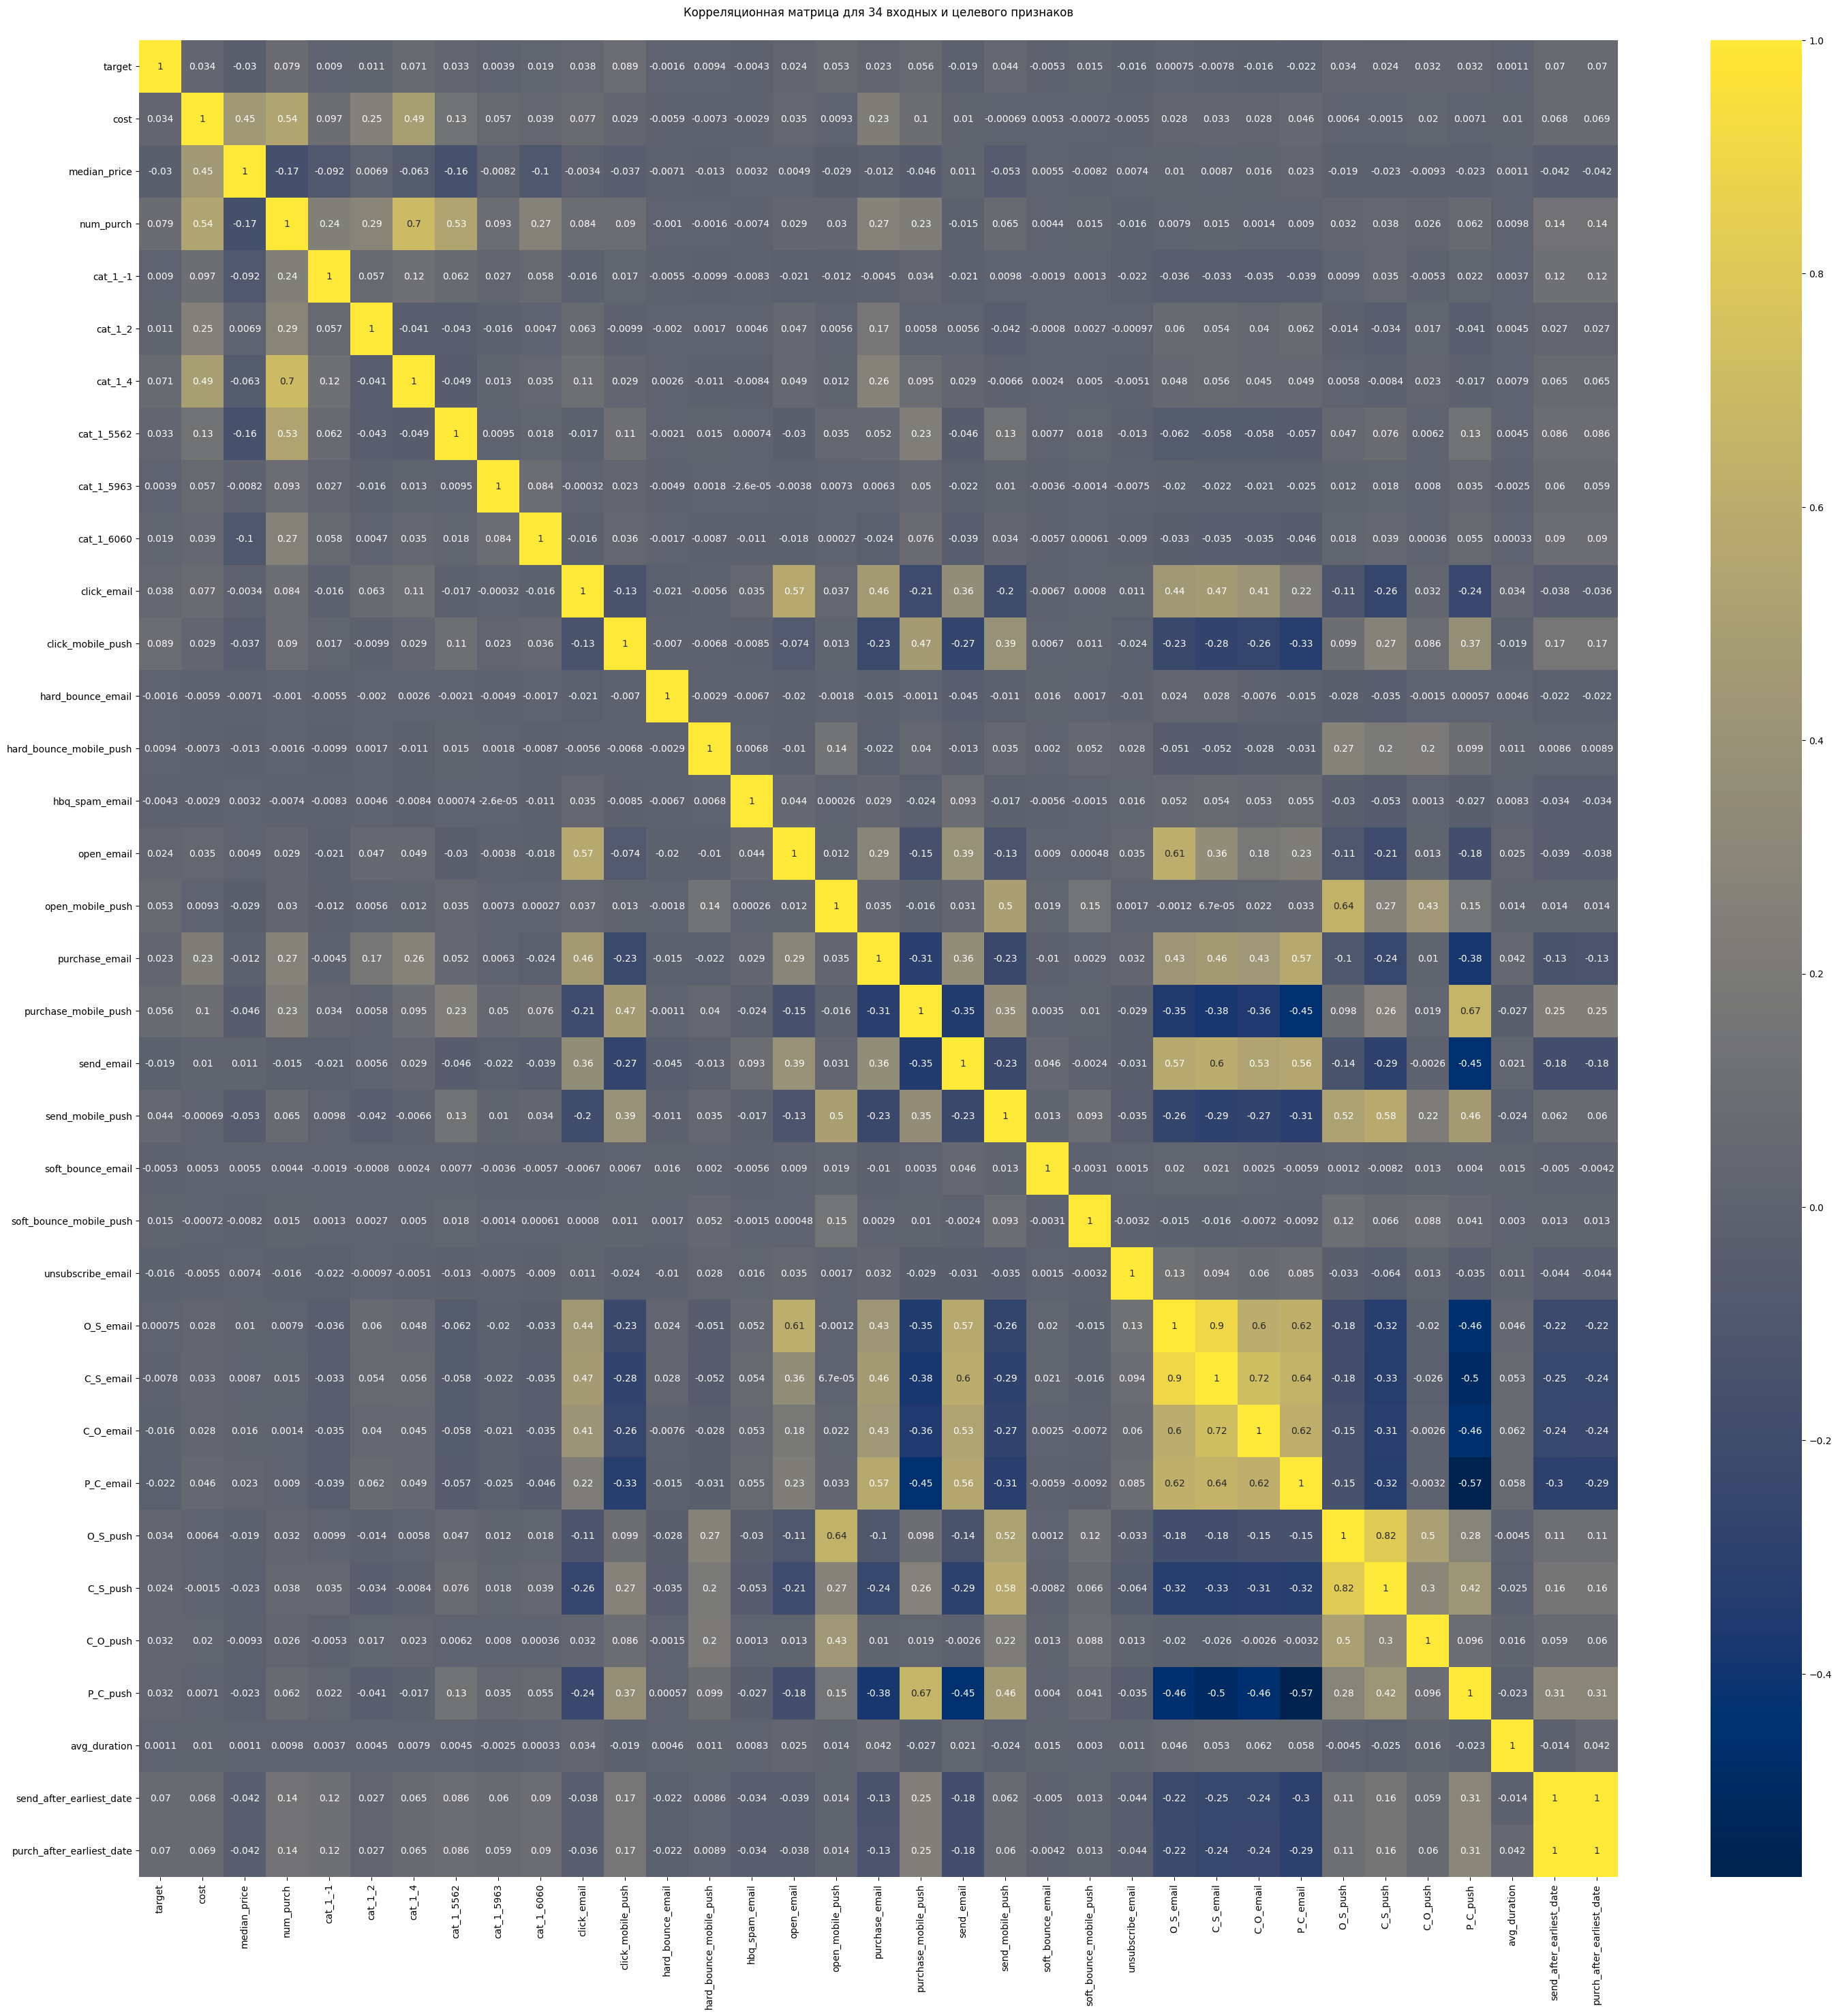

In [48]:
# Построим корреляционную матрицу для данных датафрейма 'df_result' без пропусков, выбросов и дубликатов для 34 входных признаков
# проверить method='spearman'
fig, ax = plt.subplots(figsize=(35, 35))
sns.heatmap(df_result.drop('client_id', axis=1, inplace=False).corr(), annot=True, cmap='cividis')
plt.title("Корреляционная матрица для 34 входных и целевого признаков", y=1.01);

<div align='justify' style="text-indent:2em"> 
    Как показывает визуализация, зависимости значений целевого признака от значений всех до одного входных признаков слабые или очень слабые (коэффициенты всех входных признаков в паре с целевым меньше 0,1), что, крайне вероятно, означает низкое или, в лучшем случае, невысокое качество слабых прогнозных моделей, построенных на базе этих данных. При таком уровне зависимостей в качестве класса прогнозных моделей неизбежно придётся выбирать ансамбль моделей; вероятно, с алгоритмом бустинга (пошагового усиления модели, "обучения с учителем" с целью уменьшения значений функции ошибки прогноза последовательности слабых моделей). Проверим, повлияет ли на коэффициенты корреляции упрощение модели (сокращение числа входящих признаков, как создающих мультиколлинеарность входных признаков, так и тех, что имеют наименьшие парные коэффициенты корреляции с целевым). </div>

In [49]:
# Создадим список входных признаков, имеющих наименьший парный коэффициент корреляции с целевым
cat_exclud = ['client_id', 'cat_1_-1', 'cat_1_2', 'cat_1_5562', 'cat_1_5963', 'cat_1_6060', 'hard_bounce_email', 'hard_bounce_mobile_push', \
                'hbq_spam_email', 'soft_bounce_email', 'soft_bounce_mobile_push', 'send_after_earliest_date']

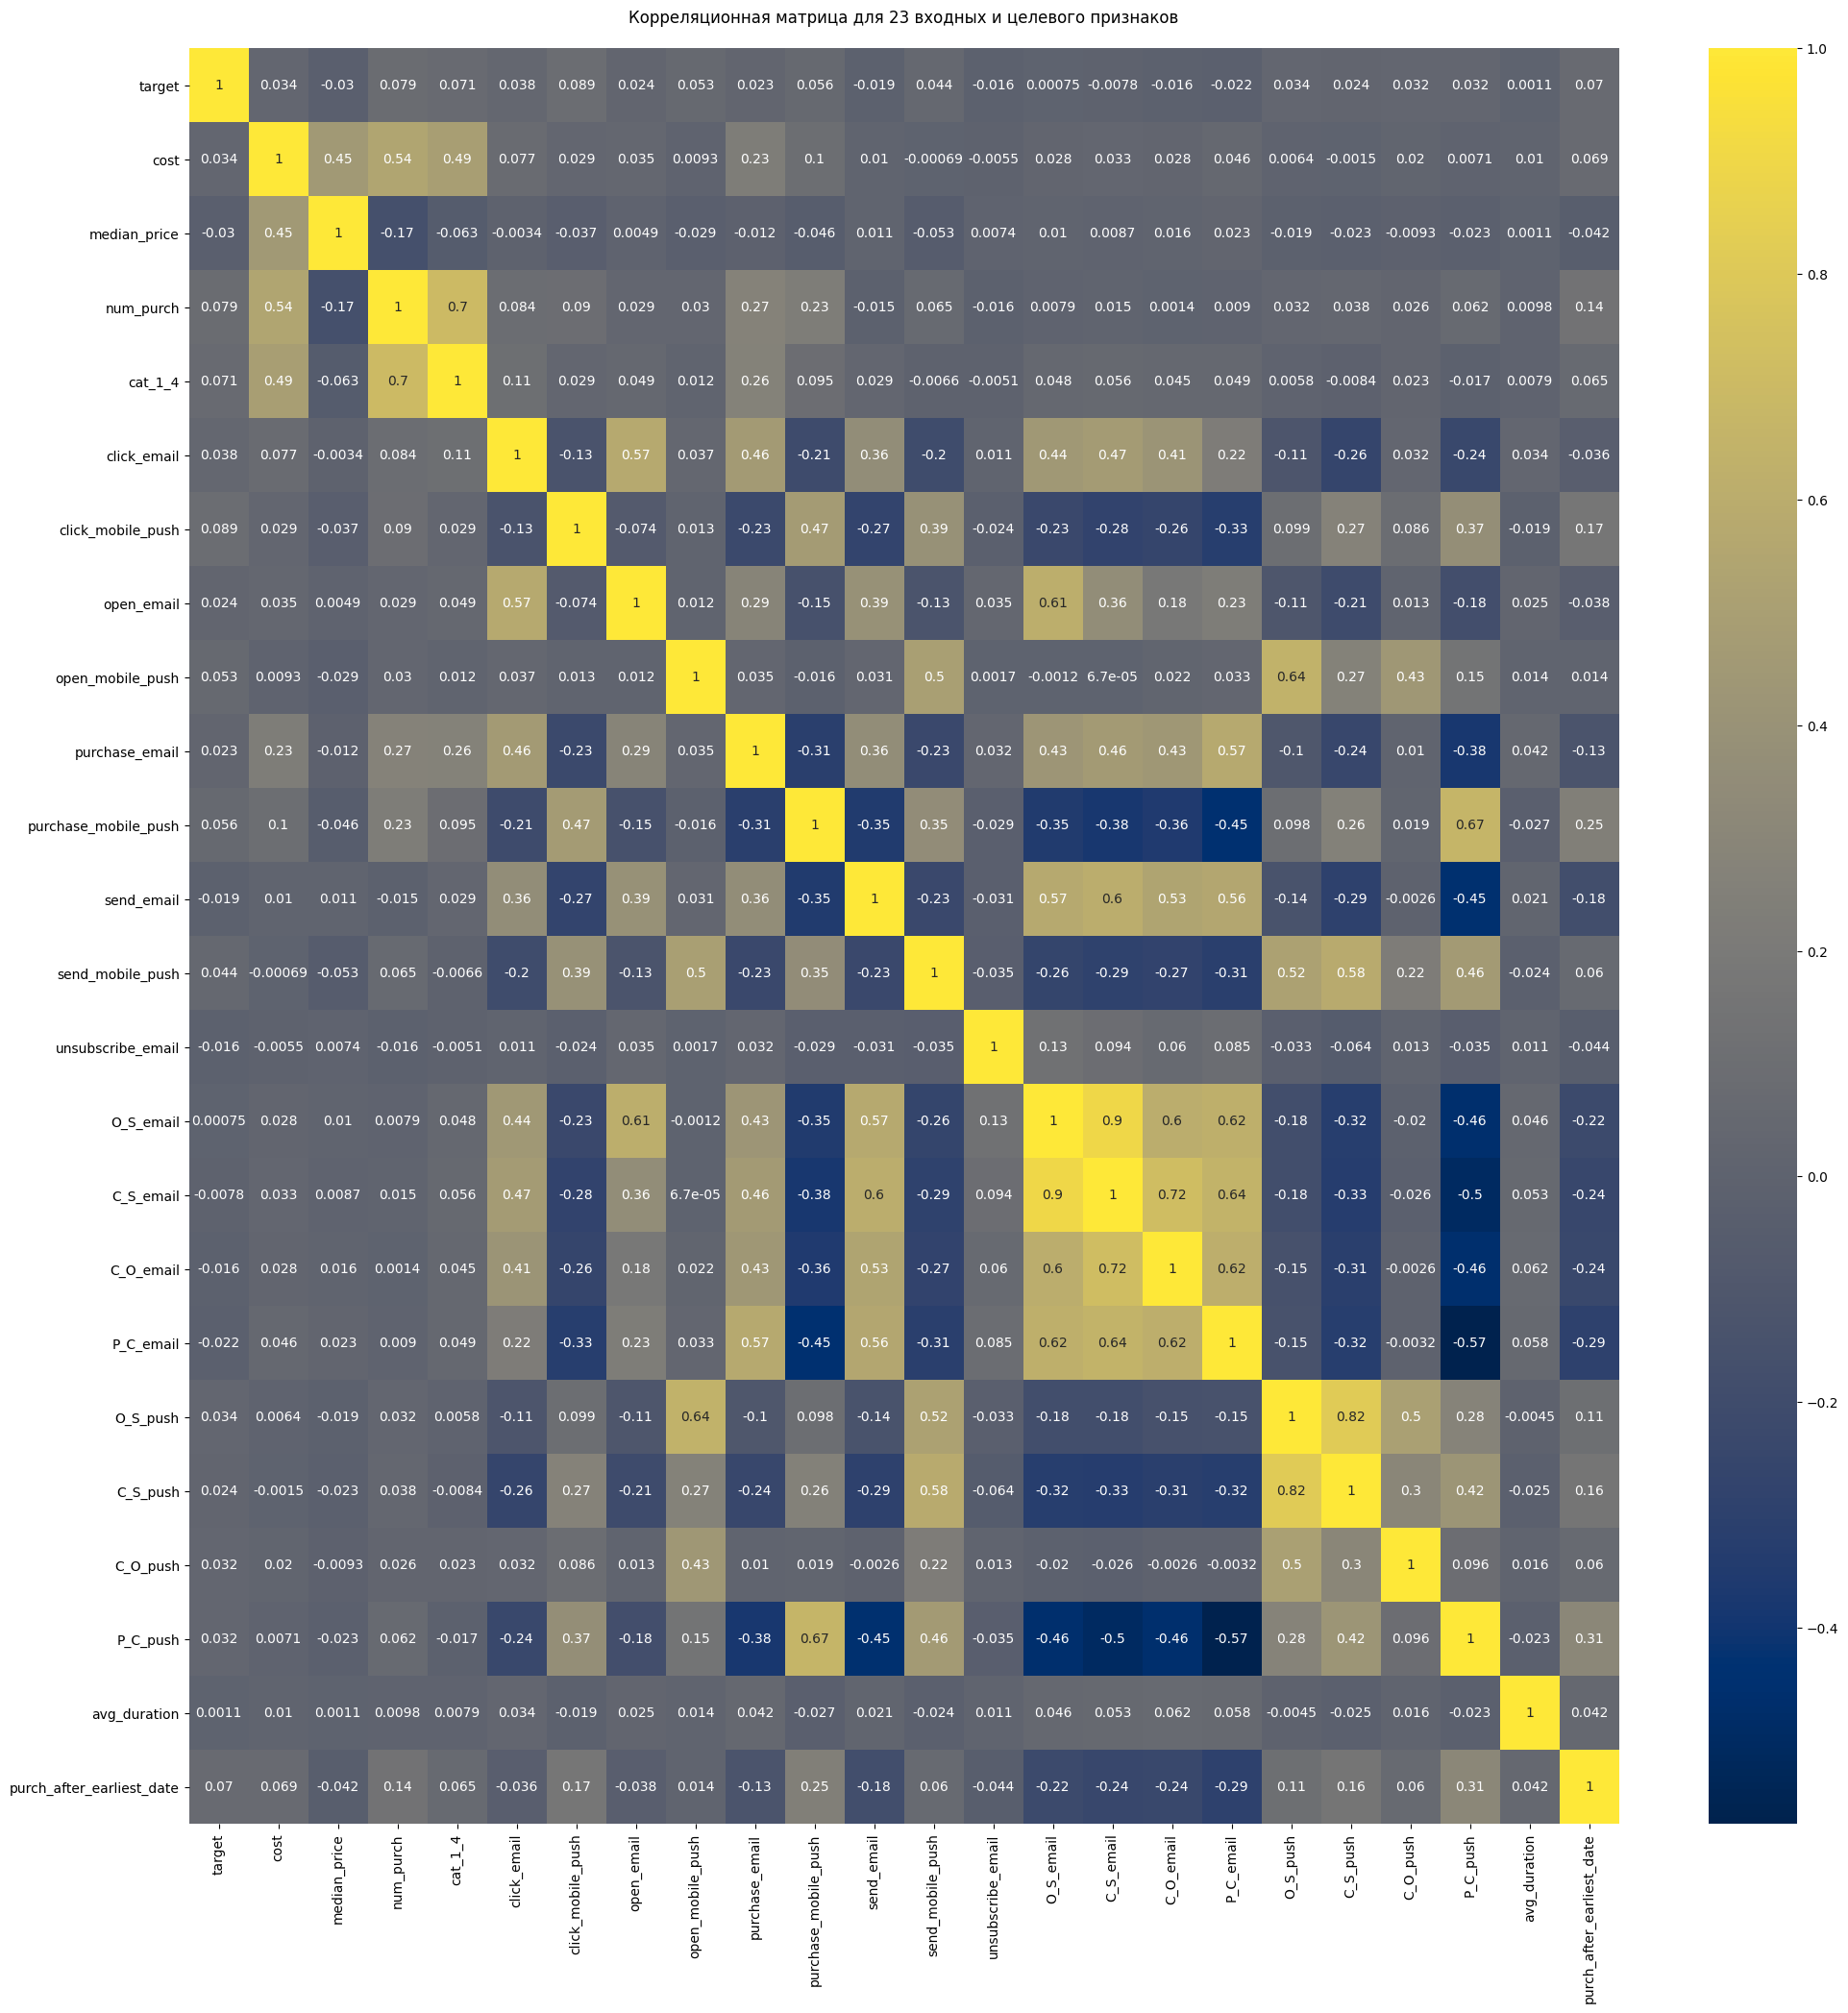

In [50]:
# Построим корреляционную матрицу для данных датафрейма 'df_result' без пропусков, выбросов и дубликатов для 23 входных признаков
fig, ax = plt.subplots(figsize=(24, 24))
sns.heatmap(df_result.drop(cat_exclud, axis=1, inplace=False).corr(), annot=True, cmap='cividis')
plt.title("Корреляционная матрица для 23 входных и целевого признаков", y=1.01);

<div align='justify' style="text-indent:2em"> 
    Как показывает диаграмма, упрощение модели не повлекло заметного увеличения парных коэффициентов корреляции входных признаков с целевым (все соответствующие значения остались меньшими 0,1). Это, по-видимому, означает, что упрощение модели может не привести и к повышение её качества (увеличению значения метрики). 
    <br> &emsp;&emsp;В завершение этого раздела проекта отделим целевой признак от входящих и каждую из этих групп разделим на две выборки: тренировочную (для цели обучения прогнозной модели) и тестовую (для оценки качества прогнозной модели, обученной на тренировочной выборке). </div>

In [51]:
# Разделим данные на матрицу значений входящих признаков и столбец значений целевого признака
X_full = df_result.drop(['client_id', 'target'], axis=1, inplace=False)
y = df_result['target']

In [52]:
# Разделим данные на тренировочную и тестовую выборки в пропорции 3:1
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, y, test_size=0.25, random_state=RANDOM_STATE)

<div align='justify' style="text-indent:2em"> <b>
    Подведём итог первого раздела проекта. В проект импортировано необходимое программное обеспечение, загружены и описаны данные Заказчика. Из этих данных сформирован широкий (полный) набор 35 входных признаков с данными без дубликатов, выбросов и пропусков. При этом каждый входной признак имеет низкий коэффициент корреляции Пирсона с целевым признаком. Крайне вероятно, что в таком случае будет необходимо использовать ансамбль слабых моделей, возможно, с алгоритмом бустинга, возможно, с упрощением модели (отбором входных признаков). Задачи первого раздела проекта выполнены. <b></div>

### 3. Моделирование.

<div align='justify' style="text-indent:2em"> Начнём поиск наилучшей модели прогноза класса клиентов Заказчика с простой модели класса логистической регрессии, затем проверим качество ансамбля случайного леса. Выбор класса ансамблей моделей обусловлен их возможностью "находить" даже слабые нелинейные зависимости целевого признака от входных признаков, а также относительно низкой чувствительностью к мультиколлинеарности признаков. Начальные гиперпараметры модели подберём "вручную" методом "проб и ошибок" так, чтобы, если это получится, среднее значение метрики обученной модели на валидационных выборках (на кросс-валидации) и значение метрики на тестовой выборке были выше порога, установленного Заказчиком. Отдельно можно обратить внимание на практическую неприменимость в этом проекте модели опорных векторов: по данным в сети такая модель с числом наблюдений (строк) около 50 000 и 35 признаками может прогнозировать классы в течение пяти часов и более, поэтому проверку качества модели, построенной на алгоритме опорных векторов в этом проекте проводить не будем.</div>

In [53]:
# Создадим экземпляр нормализатора класса 'StandardScaler' для нормализации данных перед применением модели класса логистической регрессии
scaler = StandardScaler()

# Обучим экземпляр нормализатора на данных входных признаков тренировочной выборки и применим его к аналогичным данным тестовой выборки
X_train_full_scaled = scaler.fit_transform(X_train_full)
X_test_full_scaled = scaler.transform(X_test_full)

# Создадим экземпляр модели класса логистической регрессии и обучим её на нормализованных данных тренировочной выборки
model_lg = LogisticRegression(max_iter=100, class_weight='balanced', random_state=RANDOM_STATE, verbose=0)
model_lg_full = model_lg.fit(X_train_full_scaled, y_train_full)

In [54]:
# Вычислим среднее значение метрики ROC-AUC модели логистической регрессии с полным набором признаков на кросс-валидации 
# и значение этой метрики на тестовой выборке
roc_auc_lg_full_cv_mean = calc_metric(model_lg, X_train_full_scaled, y_train_full)
print(f'Среднее значение метрики ROC-AUC модели LogisticRegression с полным набором признаков на кросс-валидации: \
{np.round(roc_auc_lg_full_cv_mean, 4)}.')

y_proba_lg_full_test = model_lg_full.predict_proba(X_test_full_scaled)[:, 1]
roc_auc_lg_full_test = round(roc_auc_score(y_test_full, y_proba_lg_full_test), 4)
print(f'Значение метрики ROC-AUC модели LogisticRegression с полным набором признаков на тестовой выборке: \
{roc_auc_lg_full_test}.')

Среднее значение метрики ROC-AUC модели LogisticRegression с полным набором признаков на кросс-валидации: 0.7212.
Значение метрики ROC-AUC модели LogisticRegression с полным набором признаков на тестовой выборке: 0.7004.


<div align='justify' style="text-indent:2em"> Метрика модели класса логистической регрессии едва-едва удовлетворила требование Заказчика. Качество модели оказалось на грани, но всё-таки приемлемым. Попробуем улучшить качество модели применением к данным Заказчика модели класса случайного леса. </div>

In [57]:
# Изменим некоторые гиперпараметры экземпляра модели класса RandomForestClassifier и обучим её на данных тренировочной выборки
model_rfc = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_split=2, min_samples_leaf=2, max_features=6, \
                                   verbose=0, class_weight='balanced', random_state=RANDOM_STATE)
model_rfc_full = model_rfc.fit(X_train_full, y_train_full)

In [58]:
# Повторно вычислим среднее значение метрики ROC-AUC модели RandomForestClassifier с полным набором признаков на кросс-валидации 
# и значение этой метрики на тестовой выборке
roc_auc_rfc_full_cv_mean = calc_metric(model_rfc, X_train_full, y_train_full)
print(f'Среднее значение метрики ROC-AUC модели RandomForestClassifier с полным набором признаков на кросс-валидации: \
{np.round(roc_auc_rfc_full_cv_mean, 4)}.')

y_proba_rfc_full_test = model_rfc_full.predict_proba(X_test_full)[:, 1]
roc_auc_rfc_full_test = round(roc_auc_score(y_test_full, y_proba_rfc_full_test), 4)
print(f'Значение метрики ROC-AUC модели RandomForestClassifier с полным набором признаков на тестовой выборке: \
{roc_auc_rfc_full_test}.')

Среднее значение метрики ROC-AUC модели RandomForestClassifier с полным набором признаков на кросс-валидации: 0.7356.
Значение метрики ROC-AUC модели RandomForestClassifier с полным набором признаков на тестовой выборке: 0.7301.


<div align='justify' style="text-indent:2em"> Метрика модели класса 'RandomForestClassifier' соответствует требованиям Заказчика. Качество модели является приемлемым. Попробуем продолжить поиск наилучшей модели, применив к данным Заказчика ансамбли моделей класса 'LGBMClassifier' с алгоритмом градиентного бустинга, также "вручную" подобрав значения её гиперпараметров. </div>

In [59]:
# Создадим экземпляр модели класса LGBMClassifier и обучим её на данных тренировочной выборки
model_lgbmc = LGBMClassifier(n_estimators=90, num_leaves=4, max_depth=15, min_child_samples=20, reg_alpha=0.5, reg_lambda=0.2, \
                                     verbose=-1, class_weight='balanced', random_state=RANDOM_STATE)
model_lgbmc_full = model_lgbmc.fit(X_train_full, y_train_full)

In [60]:
# Вычислим среднее значение метрики ROC-AUC модели LGBMClassifier с полным набором признаков на кросс-валидации
# и значение этой метрики на тестовой выборке
roc_auc_lgbmc_full_cv_mean = calc_metric(model_lgbmc, X_train_full, y_train_full)
print(f'Среднее значение метрики ROC-AUC модели LGBMClassifier с полным набором признаков на кросс-валидации: \
{np.round(roc_auc_lgbmc_full_cv_mean, 4)}.')

y_proba_lgbmc_full_test = model_lgbmc_full.predict_proba(X_test_full)[:, 1]
roc_auc_lgbmc_full_test = round(roc_auc_score(y_test_full, y_proba_lgbmc_full_test), 4)
print(f'Значение метрики ROC-AUC модели LGBMClassifier с полным набором признаков на тестовой выборке: \
{roc_auc_lgbmc_full_test}.')

Среднее значение метрики ROC-AUC модели LGBMClassifier с полным набором признаков на кросс-валидации: 0.7326.
Значение метрики ROC-AUC модели LGBMClassifier с полным набором признаков на тестовой выборке: 0.7272.


<div align='justify' style="text-indent:2em"> Метрика ансамбля моделей класса 'LGBMClassifier' с полным набором (35) признаков на данных тестовой выборки также соответствует требованиям Заказчика, однако немного меньше соответствующего значения метрики ансамбля класса 'RandomForestClassifier'. Попробуем продолжить поиск наилучшей модели, применив к данным Заказчика ансамбль моделей класса 'CatBoostClassifier' с другим алгоритмом градиентного бустинга, "вручную" подобрав значения её гиперпараметров. </div>

In [61]:
# Создадим экземпляр модели класса CatBoostClassifier и обучим её на данных тренировочной выборки
model_cbc = CatBoostClassifier(iterations=110, depth=3, class_weights=[237, 12226], learning_rate=0.15, verbose=0, l2_leaf_reg=10, \
                               random_strength=0.6, random_state=RANDOM_STATE)
model_cbc_full = model_cbc.fit(X_train_full, y_train_full)

In [62]:
# Вычислим среднее значение метрики ROC-AUC модели CatBoostClassifier с полным набором признаков на кросс-валидации
# и значение этой метрики на тестовой выборке
roc_auc_cbc_full_cv_mean = calc_metric(model_cbc, X_train_full, y_train_full)
print(f'Среднее значение метрики ROC-AUC модели CatBoostClassifier с полным набором признаков на кросс-валидации: \
{np.round(roc_auc_cbc_full_cv_mean, 4)}.')

y_proba_cbc_full_test = model_cbc_full.predict_proba(X_test_full)[:, 1]
roc_auc_cbc_full_test = round(roc_auc_score(y_test_full, y_proba_cbc_full_test), 4)
print(f'Значение метрики ROC-AUC модели CatBoostClassifier с полным набором признаков на тестовой выборке: \
{roc_auc_cbc_full_test}.')

Среднее значение метрики ROC-AUC модели CatBoostClassifier с полным набором признаков на кросс-валидации: 0.7336.
Значение метрики ROC-AUC модели CatBoostClassifier с полным набором признаков на тестовой выборке: 0.7302.


<div align='justify' style="text-indent:2em"> Значение метрики модели класса 'CatBoostClassifier' с полным набором (35) признаков на данных тестовой выборки также соответствует требованиям Заказчика, равно 0,7302 и является наибольшим среди вычисленных (на 0,0001 лучше, чем соответствующее лучшее значение метрики модели класса 'RandomForestClassifier'). Попробуем продолжить поиск наилучшей модели, применив в цикле ко всем выбранным классам моделей стандартный оптимизатор со случайным поиском оптимальных значений гиперпараметров моделей в заданной сетке поиска. </div>

In [63]:
# Зададим словарь моделей и сетки гиперпараметров для каждой модели в RandomizedSearchCV
models = {
    'RandomForestClassifier': {
        'model': RandomForestClassifier(verbose=0, class_weight='balanced', random_state=RANDOM_STATE),
        'params': {
            'n_estimators': [70, 90, 110, 130, 150],
            'max_depth': [4, 6, 8, 10],
            'min_samples_split': [2, 3, 4, 5],
            'min_samples_leaf': [2, 4, 6, 8],
            'max_features': [3, 4, 5],
        }
    },
    'CatBoostClassifier': {
        'model': CatBoostClassifier(verbose=0, class_weights=[237, 12226], random_state=RANDOM_STATE),
        'params': {
            'iterations': [80, 100, 120, 150, 200],
            'depth': [2, 3, 4],
            'learning_rate': [0.05, 0.1, 0.2],
            'l2_leaf_reg': [5, 15, 25],
        }
    },
    'LGBMClassifier': {
        'model': LGBMClassifier(verbose=-1, class_weight='balanced', random_state=RANDOM_STATE), 
        'params': {
            'n_estimators': [50, 70, 100, 130, 150],
            'num_leaves': [2, 4, 6, 8],
            'max_depth': [5, 10, 15, 20],
            'min_child_samples': [10, 20, 30],
            'reg_alpha': [0.1, 0.2, 0.5, 0.7],
            'reg_lambda': [0.1, 0.2, 0.3],
        }
    }
}

# Создадим цикл обучения моделей в словаре со случайным перебором (10 итераций) наборов гиперпараметров этих моделей в заданной сетке
best_models = {}
for name, config in models.items():
    print(f'Процесс обучения модели {name} начался.')
    model = config['model']
    params = config['params']
    
    # Создадим экземпляр класса RandomizedSearchCV
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=params,
        n_iter=10,  
        scoring='roc_auc',
        cv=5,
        n_jobs=-1,
        random_state=42
    )
    
    # Обучим модель в RandomizedSearchCV на тренировочной выборке с полным набором признаков
    search.fit(X_train_full, y_train_full)
    
    # Сохраним лучшую модель в каждом классе 
    best_models[name] = search.best_estimator_
    # Сохраним значения гиперпараметров лучшей модели в классе
    best_params = search.best_params_
    print(f'Значения гиперпараметров лучшей в RandomizedSearchCV модели в классе {name}: \n{best_params}.')
    
    # Вычислим значение метрики  на тестовой выборке
    y_pred_proba = search.predict_proba(X_test_full)[:, 1]
    roc_auc = roc_auc_score(y_test_full, y_pred_proba)
    print(f'Значение метрики ROC-AUC лучшей в RandomizedSearchCV модели класса {name} с полным набором признаков \
    на тестовой выборке: {round(roc_auc, 4)}.\n')

Процесс обучения модели RandomForestClassifier начался.
Значения гиперпараметров лучшей в RandomizedSearchCV модели в классе RandomForestClassifier: 
{'n_estimators': 70, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 4, 'max_depth': 6}.
Значение метрики ROC-AUC лучшей в RandomizedSearchCV модели класса RandomForestClassifier с полным набором признаков     на тестовой выборке: 0.7268.

Процесс обучения модели CatBoostClassifier начался.
Значения гиперпараметров лучшей в RandomizedSearchCV модели в классе CatBoostClassifier: 
{'learning_rate': 0.2, 'l2_leaf_reg': 25, 'iterations': 80, 'depth': 4}.
Значение метрики ROC-AUC лучшей в RandomizedSearchCV модели класса CatBoostClassifier с полным набором признаков     на тестовой выборке: 0.7255.

Процесс обучения модели LGBMClassifier начался.
Значения гиперпараметров лучшей в RandomizedSearchCV модели в классе LGBMClassifier: 
{'reg_lambda': 0.3, 'reg_alpha': 0.1, 'num_leaves': 8, 'n_estimators': 50, 'min_child_samples': 30,

<div align='justify' style="text-indent:2em"> В результате использования оптимизатора RandomizedSearchCV со случайным поиском оптимальных гиперпараметров на заданной сетке их значений из лучших моделей трёх классов наибольшее значение метрики ROC-AUC на данных тестовой выборки с полным набором (35) признаков оказалось у модели класса 'LGBMClassifier' со следующими гиперпараметрами (n_estimators=50, num_leaves=8, min_child_samples=30, max_depth=10, reg_alpha=0.1, reg_lambda=0.3) и равно 0,7302, что совпадает с аналогичным  значением метрики модели класса 'CatBoostClassifier' с экспертным выбором гиперпараметров (iterations=110, depth=3, learning_rate=0.15, l2_leaf_reg=10, random_strength=0.6). Из этих моделей в качестве наилучшей можно выбрать любую. Применённый экземпляр случайного поиска оптимальных гиперпараметров моделей (с заданной сеткой поиска и числом переборов) не увеличил наибольшее значение метрики моделей (не помог улучшить качество модели). 
<br> &emsp;&emsp;Сделаем ещё одну (последнюю) попытку улучшить прогнозную модель: попробуем обучить экземпляр модели класса 'CatBoostClassifier' с экспертным выбором гиперпараметров на данных 20 отобранных входных признаков (с наибольшими значениями коэффициента Шепли) и вычислить метрику такой модели на тестовой выборке. </div>

In [64]:
# Создадим экземпляр интерпретатора SHAP для модели CatBoostClassifier
explainer_cbc = shap.TreeExplainer(model_cbc)

# Вычислим числа (коэффициенты) Шепли для полного набора (35) входных признаков в модели CatBoostClassifier
shap_values_cbc_full = explainer_cbc(X_test_full)

In [65]:
# Создадим список из 20 наименований входных признаков, у которых оказались наибольшие значения коэффициентов Шепли 
# (сокращённый набор входных признаков)
mean_abs_shap = np.abs(shap_values_cbc_full.values).mean(axis=0)
feature_names = shap_values_cbc_full.feature_names
important_features_cbc = pd.Series(mean_abs_shap, index=feature_names).sort_values(ascending=False).head(20).index.tolist()

# Создадим тренировочную и тестовую выборки с сокращённым набором входных признаков
X_train_imp = X_train_full[important_features_cbc]
X_test_imp = X_test_full[important_features_cbc]

# Обучим экземпляр модели класса CatBoostClassifier на данных тренировочной выборки с сокращённым набором входных признаков
model_cbc_imp = model_cbc.fit(X_train_imp, y_train_full)

# Вычислим среднее значение метрики ROC-AUC модели CatBoostClassifier с сокращённым набором входных признаков на кросс-валидации
# и значение этой метрики на тестовой выборке
roc_auc_cbc_imp_cv_mean = calc_metric(model_cbc, X_train_imp, y_train_full)
print(f'Среднее значение метрики ROC-AUC модели CatBoostClassifier с сокращённым набором признаков на кросс-валидации: \
{np.round(roc_auc_cbc_imp_cv_mean, 4)}.')
y_proba_cbc_imp_test = model_cbc_imp.predict_proba(X_test_imp)[:, 1]
roc_auc_cbc_imp_test = round(roc_auc_score(y_test_full, y_proba_cbc_imp_test), 4)
print(f'Значение метрики ROC-AUC модели CatBoostClassifier с сокращённым набором признаков на тестовой выборке: \
{roc_auc_cbc_imp_test}.')

Среднее значение метрики ROC-AUC модели CatBoostClassifier с сокращённым набором признаков на кросс-валидации: 0.7403.
Значение метрики ROC-AUC модели CatBoostClassifier с сокращённым набором признаков на тестовой выборке: 0.7354.


<div align='justify' style="text-indent:2em"> Упрощение прогнозной модели несколько увеличило значения её метрик как на кросс-валидации, так и на тестовой выборке (и сохранило приемлемость модели по критерию Заказчика).  Упрощать модель можно. В завершение этого раздела применением DummyClassifier(strategy='most_frequent') к данным Заказчика с сокращённым набором входных признаков проверим, что метрики рассмотренных в этом разделе моделей не случайны (значение метрики ROC-AUC dummy-модели должно заметно отличаться от значений метрик сложных прогнозных моделей и равняться точно или приблизительно 0,5). </div>

In [66]:
# Обучим экземпляр простейшей модели класса DummyClassifier на данных тренировочной выборки с сокращённым набором входных признаков
model_dummy = DummyClassifier(strategy='most_frequent')
model_dummy_imp = model_dummy.fit(X_train_imp, y_train_full)

# Вычислим значение метрики ROC-AUC модели DummyClassifier с сокращённым набором входных признаков на тестовой выборке
y_pred_proba_dummy_imp_test = model_dummy.predict_proba(X_test_imp)[:, 1]
roc_auc_dummy_imp_test = round(roc_auc_score(y_test_full, y_pred_proba_dummy_imp_test), 4)
print(f'Значение метрики ROC-AUC модели DummyClassifier с сокращённым набором признаков на тестовой выборке: \
{roc_auc_dummy_imp_test}.')

Значение метрики ROC-AUC модели DummyClassifier с сокращённым набором признаков на тестовой выборке: 0.5.


<div align='justify' style="text-indent:2em"> <b>
    Подведём итог второго раздела проекта. В проекте были созданы, обучены и протестированы модели (классификаторы) четырёх классов: логистической регрессии, случайного леса, LGBMClassifier и CatBoostClassifier с экспертным и программным поиском оптимальных гиперпараметров, с полным (35) и сокращённым (20) набором входных признаков. Значения метрик ROC-AUC всех экземпляров моделей всех классов и с упрощением модели (отбором входных признаков), и без упрощения и на кросс-валидации, и на тестовой выборке оказались выше порога, установленного Заказчиком, то есть приемлемыми. Наибольшее значение метрики было вычислено у экземпляра модели класса CatBoostClassifier с экспертным выбором гиперпараметров и сокращённым набором (20) входных  признаков (метрика ROC-AUC этой модели равна 0,7354). Эта модель может быть рекомендована Заказчику как наилучшая. Задачи второго раздела проекта выполнены. <b></div>

### 4. Анализ рекомендованной модели.

<div align='justify' style="text-indent:2em"> В этом разделе рассмотрим визуализацию матрицы ошибок рекомендованной Заказчику прогнозной модели, полученной на тестовой выборке, и визуализацию shap-анализа важности входных признаков. </div>

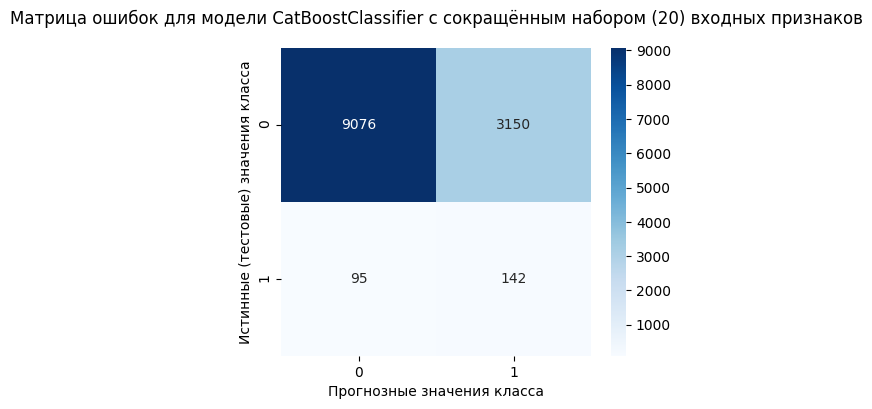

In [67]:
y_proba_cbc_imp_test = model_cbc_imp.predict(X_test_imp)
conf_matrix_cbc_full= confusion_matrix(y_test_full, y_proba_cbc_imp_test)

plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_cbc_full, annot=True, fmt="d", cmap="Blues")
plt.title("Матрица ошибок для модели CatBoostClassifier с сокращённым набором (20) входных признаков", y=1.05)
plt.xlabel("Прогнозные значения класса")
plt.ylabel("Истинные (тестовые) значения класса");

<div align='justify' style="text-indent:2em"> Как показывает визуализация матрицы ошибок, даже при приемлемом для Заказчика значении метрики модель для целей её применения остаётся довольно слабой: на данных тестовой выборке она правильно прогнозирует класс 1 лишь у около 60% клиентов, которых Заказчик маркировал классом 1 (как готовых к совершению новых покупок в течение 90 дней со дня проведения такой оценки). Это, как и матрица корреляции, прямо указывает на то, что данных предоставленных Заказчиком, недостаточно для построения сильной модели. Отсюда следуют две основные рекомендации Заказчику: первая, привлечь к работе по прогнозированию покупательской активности специалистов-маркетологов с целью разработки списка таких входных признаков, значения которых будут иметь сильную статистическую корреляцию с покупательской активностью клиентов, и вторая, наладить такой автоматизированный учёт взаимодействия Заказчика с клиентом, который позволит накопить данные по этим входным признакам. </div>

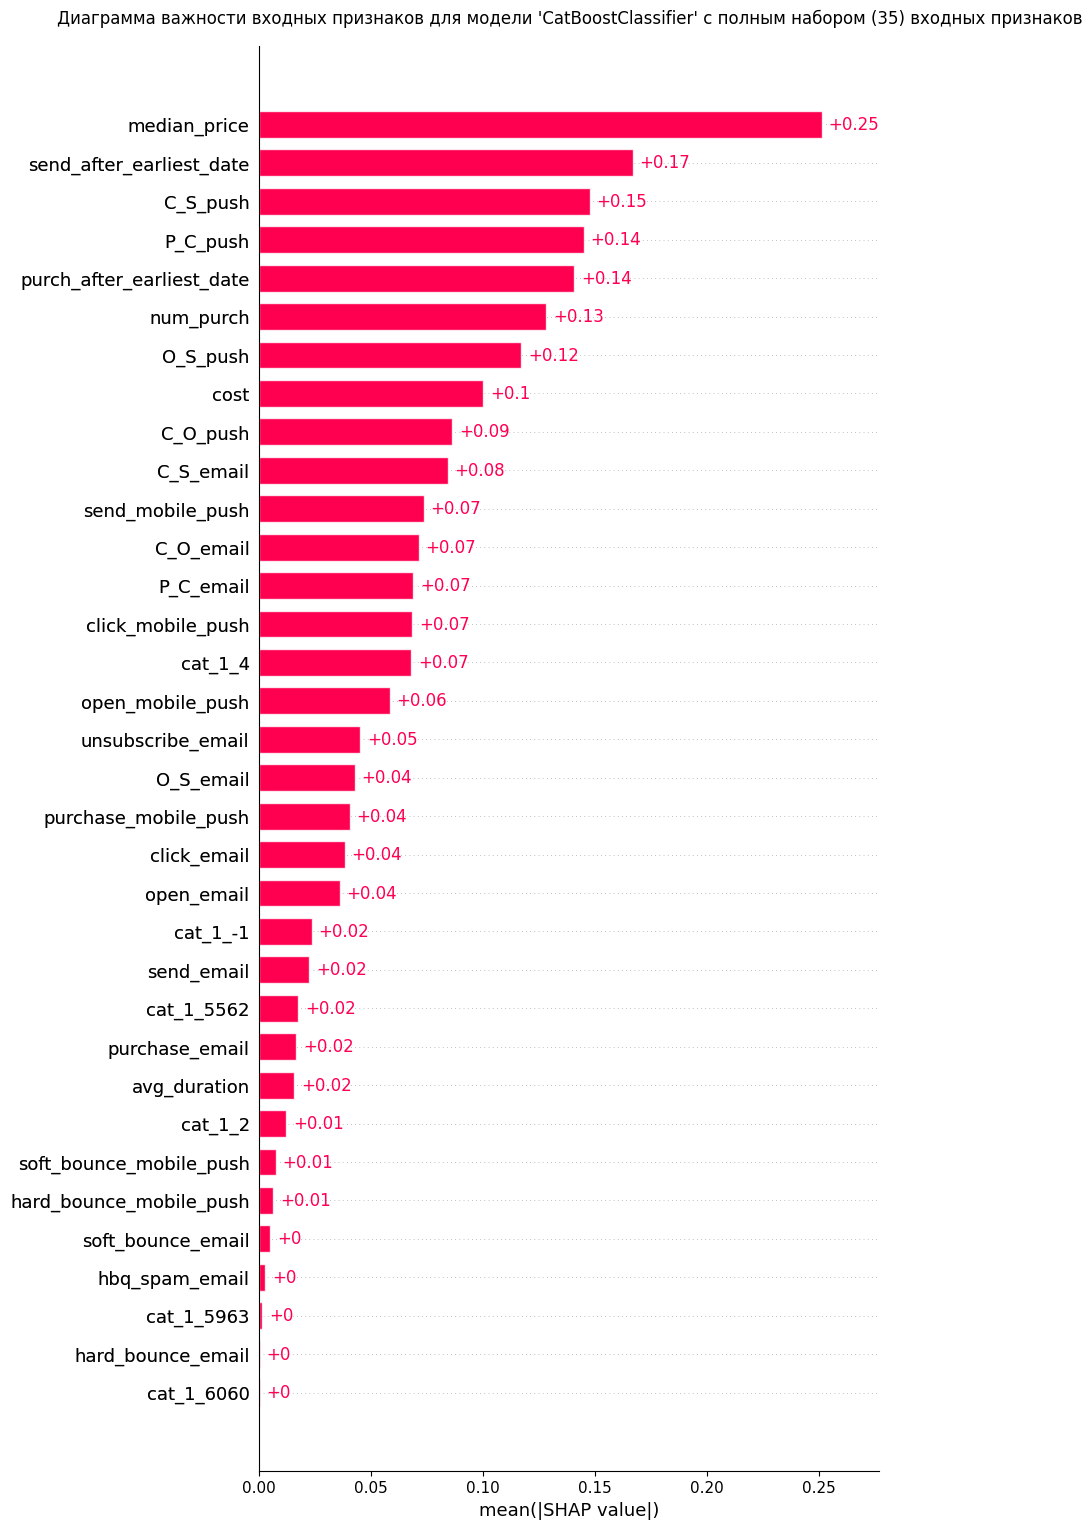

In [68]:
# Визуализируем "вклад" каждого входного признака (из 35) в прогноз значения целевого признака 
shap.plots.bar(shap_values_cbc_full, max_display=40, show=False)
plt.title("Диаграмма важности входных признаков для модели 'CatBoostClassifier' с полным набором (35) входных признаков", y=1.01);

<div align='justify' style="text-indent:2em"> Визуализация коэффициентов Шепли показала, что в этом проекте наиболее важными входными признаками прогнозной модели являются средняя цена покупок клиента, давность его рекламного информирования и его покупок, число таких покупок и некоторые коэффициенты его маркетинговой конверсии. </div>

<div align='justify' style="text-indent:2em"> <b>
    Подведём итог третьего раздела проекта. В этом разделе были проанализированы матрица ошибок прогнозной модели и важность входных признаков. Этот анализ позволил сделать вывод о недостаточности имеющихся данных для создания сильной прогнозной модели, необходимой Заказчику. Заказчику были даны рекомендации по накоплению необходимых данных. Задачи третьего раздела проекта выполнены. <b></div>

### 5. Итоги проекта.

<div align='justify' style="text-indent:2em"> <b>
    В соответствии с техническим заданием в проект было импортировано необходимое программное обеспечение, загружены и описаны данные Заказчика. Эти данные были предобработаны (удалены дубликаты, проверено отсутствие выбросов и пропусков). Были экспертным образом сформулированы гипотезы о признаках, значения которых могут иметь статистическую зависимость со значениями целевого признака (классов покупательской активности клиентов). Данные Заказчика были трансформированы таким образом, чтобы получить значения этих входных признаков. Были созданы, обучены и протестированы несколько прогнозных моделей для полного и сокращённого набора входных признаков. По критерию максимизации значения определённой Заказчиком метрики прогнозной модели была выбрана наилучшая модель с метрикой большей пороговой, установленной Заказчиком. Эта модель с наибольшей метрикой была рекомендована Заказчику. Была проанализирована матрица ошибок рекомендованной модели, в соответствии с этим анализом Заказчику были даны рекомендации по накоплению данных для улучшения результатов необходимого Заказчику прогнозирования. Задачи проекта выполнены. <b></div>